In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile
# import scikit-iag
import numpy as np
import matplotlib.pyplot as plt
import glob 
from skimage import io
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.morphology import erosion, dilation


import cv2
import pandas as pd

import os
import random

In [ ]:
root_dir = 'gdrive/MyDrive/Colab Notebooks/iris/dataset/images'
images = []
labels = os.listdir(root_dir)
for label in labels:
  folder = os.listdir(os.path.join(root_dir, label))

  for image in folder:
    images.append(os.path.join(root_dir,label,image))
# random.shuffle(images)
images.sort()  

In [ ]:
root_dir = 'gdrive/MyDrive/Colab Notebooks/iris/dataset/groundtruth'
groundtruth = []
labels = os.listdir(root_dir)
for label in labels:
    groundtruth.append(os.path.join(root_dir,label))
groundtruth.sort()


In [ ]:
from scipy import signal
from scipy.ndimage import convolve
from skimage.transform import radon
import numpy as np
def searchInnerBound(img):
    """
    Searching of the boundary (inner) of the iris
    """

    # integro-differential
    Y = img.shape[0]
    X = img.shape[1]
    sect = X/4 		
    minrad = 15
    maxrad = sect*0.8
    jump = 4 		# Precision of the search

    # Hough Space
    sz = np.array([np.floor((Y-2*sect)/jump),
                    np.floor((X-2*sect)/jump),
                    np.floor((maxrad-minrad)/jump)]).astype(int)

    #circular integration
    integrationprecision = 1
    angs = np.arange(0, 2*np.pi, integrationprecision)
    x, y, r = np.meshgrid(np.arange(sz[1]),
                          np.arange(sz[0]),
                          np.arange(sz[2]))
    y = sect + y*jump
    x = sect + x*jump
    r = minrad + r*jump
    hs = ContourIntegralCircular(img, y, x, r, angs)

    # Hough Space Partial Derivative 
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

    # blurring the image
    sm = 3
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")

    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

    inner_y = sect + y*jump
    inner_x = sect + x*jump
    inner_r = minrad + (r-1)*jump

    # Integro-Differential 
    integrationprecision = 0.1
    angs = np.arange(0, 2*np.pi, integrationprecision)
    x, y, r = np.meshgrid(np.arange(jump*2),
                          np.arange(jump*2),
                          np.arange(jump*2))
    y = inner_y - jump + y
    x = inner_x - jump + x
    r = inner_r - jump + r
    hs = ContourIntegralCircular(img, y, x, r, angs)

    # Hough Space Partial Derivative 
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

    # blurring the image
    sm = 3 	
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm,sm,sm]), mode="same")
    indmax = np.argmax(hspdrs.ravel())
    y,x,r = np.unravel_index(indmax, hspdrs.shape)

    inner_y = inner_y - jump + y
    inner_x = inner_x - jump + x
    inner_r = inner_r - jump + r - 1

    return inner_y, inner_x, inner_r


def searchOuterBound(img, inner_y, inner_x, inner_r):
    """
    Searching fo the boundary (outer) of the iris 
    """
    maxdispl = np.round(inner_r*0.15).astype(int)

    minrad = np.round(inner_r/0.5).astype(int)
    maxrad = np.round(inner_r/0.3).astype(int)

    # Integration region and avoiding eyelids
    intreg = np.array([[2/6, 4/6], [8/6, 10/6]]) * np.pi

    #circular integration
    integrationprecision = 0.05
    angs = np.concatenate([np.arange(intreg[0,0], intreg[0,1], integrationprecision),
                            np.arange(intreg[1,0], intreg[1,1], integrationprecision)],
                            axis=0)
    x, y, r = np.meshgrid(np.arange(2*maxdispl),
                          np.arange(2*maxdispl),
                          np.arange(maxrad-minrad))
    y = inner_y - maxdispl + y
    x = inner_x - maxdispl + x
    r = minrad + r
    hs = ContourIntegralCircular(img, y, x, r, angs)

    # Hough Space Partial Derivative
    hspdr = hs - hs[:, :, np.insert(np.arange(hs.shape[2]-1), 0, 0)]

    # blurring
    sm = 7 	# Size of the blurring mask
    hspdrs = signal.fftconvolve(hspdr, np.ones([sm, sm, sm]), mode="same")

    indmax = np.argmax(hspdrs.ravel())
    y, x ,r = np.unravel_index(indmax, hspdrs.shape)

    outer_y = inner_y - maxdispl + y + 1
    outer_x = inner_x - maxdispl + x + 1
    outer_r = minrad + r - 1

    return outer_y, outer_x, outer_r


def ContourIntegralCircular(imagen, y_0, x_0, r, angs):
    """
       Contour/circular integral using discrete rieman
    """
    y = np.zeros([len(angs), r.shape[0], r.shape[1], r.shape[2]], dtype=int)
    x = np.zeros([len(angs), r.shape[0], r.shape[1], r.shape[2]], dtype=int)
    for i in range(len(angs)):
        ang = angs[i]
        y[i, :, :, :] = np.round(y_0 - np.cos(ang) * r).astype(int)
        x[i, :, :, :] = np.round(x_0 + np.sin(ang) * r).astype(int)
    
    # adapt x and y
    ind = np.where(y < 0)
    y[ind] = 0
    ind = np.where(y >= imagen.shape[0])
    y[ind] = imagen.shape[0] - 1
    ind = np.where(x < 0)
    x[ind] = 0
    ind = np.where(x >= imagen.shape[1])
    x[ind] = imagen.shape[1] - 1

    hs = imagen[y, x]
    hs = np.sum(hs, axis=0)
    return hs.astype(float)


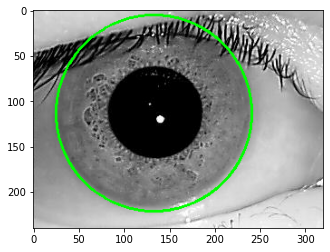

In [ ]:
img = cv2.imread(images[85])

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
i = searchInnerBound(gray)
o = searchOuterBound(gray, i[0],i[1],i[2])

plt.figure()
cv2.circle(img, (int(o[1]), int(o[0])), o[2], (0, 255, 0), 2)

plt.imshow(img, cmap = 'gray')


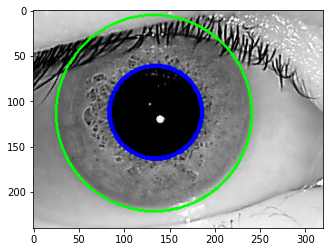

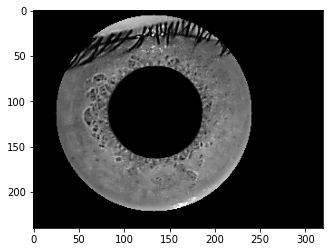

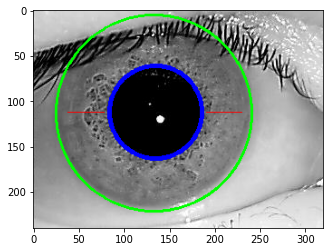

In [ ]:
img = cv2.imread(images[85])

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
i = searchInnerBound(gray)
o = searchOuterBound(gray, i[0],i[1],i[2])

plt.figure()
cv2.circle(img, (int(o[1]), int(o[0])), o[2], (0, 255, 0), 2)
cv2.circle(img, (int(i[1]), int(i[0])), i[2], (0, 0, 255), 3)
plt.imshow(img, cmap = 'gray')

mask = np.zeros_like(gray)
mask = cv2.circle(mask, (int(o[1]), int(o[0])), o[2], (255,255,255), -1)
mask = cv2.circle(mask, (int(i[1]), int(i[0])), i[2], (0,0,0), -1)
# apply mask to image
result = cv2.bitwise_and(gray, mask)

plt.figure()
plt.imshow(result, cmap = 'gray')

cv2.circle(img, (int(o[1]), int(o[0])), o[2], (0, 255, 0), 2)
cv2.circle(img, (int(i[1]), int(i[0])), i[2], (0, 0, 255), 3)

d2 = (o[2] - i[2])*4/5
d1 = 5
img[int(i[0]), int(i[1]+i[2]+d1):int(i[1]+i[2]+d2)] = (255,0,0)
img[int(i[0]), int(i[1]-i[2]-d2):int(i[1]-i[2]-d1)] = (255,0,0)

plt.figure()
plt.imshow(img, cmap = 'gray')


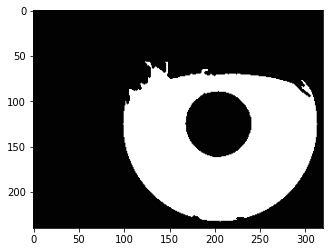

In [ ]:
mask[mask==0] = 1
mask[mask==255] = 0
mask[int(i[0]), int(i[1]+i[2]+10):int(i[1]+i[2]+50)] = 255
mask[int(i[0]), int(i[1]-i[2]-50):int(i[1]-i[2]-10)] = 255

markers = cv2.watershed(cv2.cvtColor(result, cv2.COLOR_GRAY2BGR),mask.astype(np.int32))

markers = cv2.watershed(cv2.cvtColor(result, cv2.COLOR_GRAY2BGR),mask.astype(np.int32))
img = cv2.cvtColor(result.copy(), cv2.COLOR_GRAY2BGR)
img[markers == -1] = [255,0,0]

plt.imshow(markers, cmap = 'gray')

In [ ]:
from tqdm import tqdm
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice
from skimage.segmentation import slic


100%|██████████| 38/38 [00:03<00:00, 10.98it/s]


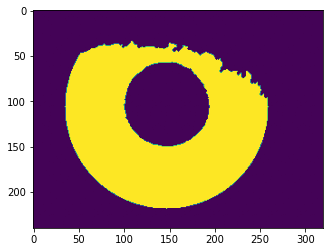

In [ ]:

score_circle = []
score_water = []
score_slc = []

for im_num in tqdm(range(len(images[887:925]))):
  img = cv2.imread(images[im_num],0)
  gt = cv2.imread(groundtruth[im_num], 0)

  i = searchInnerBound(img)
  o = searchOuterBound(img, i[0],i[1],i[2])

  mask_circle = np.zeros_like(img)
  mask_circle = cv2.circle(mask_circle, (int(o[1]), int(o[0])), o[2], (255), -1)
  mask_circle = cv2.circle(mask_circle, (int(i[1]), int(i[0])), i[2], (0), -1)



  score_circle.append(dice (gt/255, mask_circle/255))


  mask = mask_circle.copy()
  result = cv2.bitwise_and(img, mask)
  result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

  mask[mask==0] = 1
  mask[mask==255] = 0
  d2 = (o[2] - i[2])*4/5
  d1 = 5
  mask[int(i[0]), int(i[1]+i[2]+d1):int(i[1]+i[2]+d2)] = 255
  mask[int(i[0]), int(i[1]-i[2]-d2):int(i[1]-i[2]-d1)] = 255

  mask_water = cv2.watershed(result,mask.astype(np.int32))
  plt.imshow(mask_water)
  mask_water[mask_water==-1] = 0
  mask_water[mask_water== 1] = 0
  mask_water = mask_water.astype('uint8')
  mask_water = dilation(erosion(mask_water))
  score_water.append(dice (gt/255, mask_water/255))



  segments_slic = slic(result, n_segments=2, compactness=10, sigma=1)
  mask_slic = dilation(erosion(cv2.circle(segments_slic, (int(i[1]), int(i[0])), i[2], (0,0,0), -1).get()))
  score_slc.append(dice (gt/255, mask_slic))


In [ ]:
from statistics import mean
print(mean(score_circle))
print(mean(score_water))
print(mean(score_slc))

0.8667781990559539
0.9041845024766182
0.8871638789398308


<Figure size 432x288 with 0 Axes>

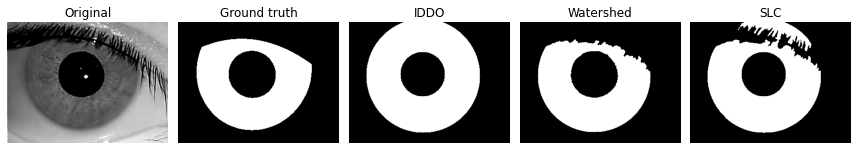

In [ ]:
plt.figure()
nrows, ncols = 1, 5
figsize = [12, 16]
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

ax[4].imshow(mask_slic, cmap = 'gray')
ax[4].title.set_text('SLC')
ax[3].imshow(mask_water, cmap = 'gray')
ax[3].title.set_text('Watershed')
ax[2].imshow(mask_circle, cmap = 'gray')
ax[2].title.set_text('IDDO')
ax[1].imshow(gt, cmap = 'gray')
ax[1].title.set_text('Ground truth')
ax[0].imshow(img, cmap = 'gray')
ax[0].title.set_text('Original')
for i in range(ncols):  
  ax[i].set_axis_off()
plt.tight_layout(True)
plt.show()

In [ ]:
img = cv2.imread(images[40],0)


i = searchInnerBound(img)
o = searchOuterBound(img, i[0],i[1],i[2])

mask = np.zeros_like(img)

mask = cv2.circle(mask, (int(o[1]), int(o[0])), o[2], (255), -1)
mask = cv2.circle(mask, (int(i[1]), int(i[0])), i[2], (0), -1)
mask_nan = mask.copy()

result = cv2.bitwise_and(img, mask)
result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

mask[mask==0] = 1
mask[mask==255] = 0
d2 = (o[2] - i[2])*4/5
d1 = 5
mask[int(i[0]), int(i[1]+i[2]+d1):int(i[1]+i[2]+d2)] = 255
mask[int(i[0]), int(i[1]-i[2]-d2):int(i[1]-i[2]-d1)] = 255

mask_water = dilation(erosion(cv2.watershed(result,mask.astype(np.int32))))
# mask_water = mask_water.astype('float')
mask_water[mask_water==-1] = 0
mask_water[mask_water== 1] = 0


mask_nan = mask_nan + mask_water
mask_nan[mask_nan== 510] = 0
mask_nan = cv2.circle(mask_nan, (int(o[1]), int(o[0])), o[2], (0), 0)
mask_nan = mask_nan.astype('float')
mask_nan[mask_nan== 255] = np.nan

result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
final = (result  + mask_nan)

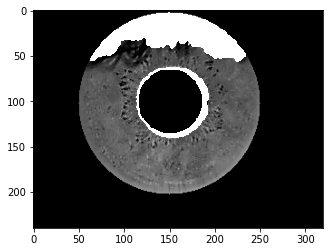

In [ ]:

plt.figure()
plt.imshow(final, cmap = 'gray')

In [ ]:
def segmentwater(img_path):
  img = cv2.imread(img_path,0)


  i = searchInnerBound(img)
  o = searchOuterBound(img, i[0],i[1],i[2])

  mask = np.zeros_like(img)

  mask = cv2.circle(mask, (int(o[1]), int(o[0])), o[2], (255), -1)
  mask = cv2.circle(mask, (int(i[1]), int(i[0])), i[2], (0), -1)
  mask_nan = mask.copy()

  result = cv2.bitwise_and(img, mask)
  result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

  mask[mask==0] = 1
  mask[mask==255] = 0
  d2 = (o[2] - i[2])*4/5
  d1 = 5
  mask[int(i[0]), int(i[1]+i[2]+d1):int(i[1]+i[2]+d2)] = 255
  mask[int(i[0]), int(i[1]-i[2]-d2):int(i[1]-i[2]-d1)] = 255

  mask_water = dilation(erosion(cv2.watershed(result,mask.astype(np.int32))))

  mask_water[mask_water==-1] = 0
  mask_water[mask_water== 1] = 0


  mask_nan = mask_nan + mask_water
  mask_nan[mask_nan== 510] = 0
  mask_nan = cv2.circle(mask_nan, (int(o[1]), int(o[0])), o[2], (0), 0)
  mask_nan = mask_nan.astype('float')
  mask_nan[mask_nan== 255] = np.nan

  result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
  final = (result  + mask_nan)
  return final, i,o
  

In [ ]:
 final, i,o = segmentwater(images[40])

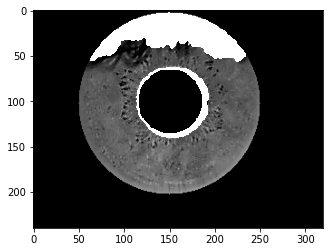

In [ ]:
plt.imshow(final, cmap = 'gray')

In [ ]:
def normalize(image, x_iris, y_iris, r_iris, x_pupil, y_pupil, r_pupil,
              radpixels, angulardiv):
    """
    Turn a circular region into a rectangular block of NxN dimensions
    """
    radiuspixels = radpixels + 2
    angledivisions = angulardiv-1

    r = np.arange(radiuspixels)
    theta = np.linspace(0, 2*np.pi, angledivisions+1)

    # displacement of pupil and iris center
    ox = x_pupil - x_iris
    oy = y_pupil - y_iris

    if ox <= 0:
        sgn = -1
    elif ox > 0:
        sgn = 1

    if ox == 0 and oy > 0:
        sgn = 1

    a = np.ones(angledivisions+1) * (ox**2 + oy**2)

    if ox == 0:
        phi = np.pi/2
    else:
        phi = np.arctan(oy/ox)

    b = sgn * np.cos(np.pi - phi - theta)

    r = np.sqrt(a)*b + np.sqrt(a*b**2 - (a - r_iris**2))
    r = np.array([r - r_pupil])

    rmat = np.dot(np.ones([radiuspixels, 1]), r)

    rmat = rmat * np.dot(np.ones([angledivisions + 1, 1]), np.array([np.linspace(0, 1, radiuspixels)])).transpose()
    rmat = rmat + r_pupil

    # exclude teh boundarys of the pupil iris border 
    rmat = rmat[1:radiuspixels-1, :]

    # cartesian location of each point around the iris
    xcosmat = np.dot(np.ones([radiuspixels-2, 1]), np.array([np.cos(theta)]))
    xsinmat = np.dot(np.ones([radiuspixels-2, 1]), np.array([np.sin(theta)]))
    xo = rmat * xcosmat
    yo = rmat * xsinmat
    xo = x_pupil + xo
    xo = np.round(xo).astype(int)
    coords = np.where(xo >= image.shape[1])
    xo[coords] = image.shape[1] - 1
    coords = np.where(xo < 0)
    xo[coords] = 0
    
    yo = y_pupil - yo
    yo = np.round(yo).astype(int)
    coords = np.where(yo >= image.shape[0])
    yo[coords] = image.shape[0] - 1
    coords = np.where(yo < 0)
    yo[coords] = 0

    polar_array = image[yo, xo]
    polar_array = polar_array / 255

    # noise array with location of NaNs in polar_array
    polar_noise = np.zeros(polar_array.shape)
    coords = np.where(np.isnan(polar_array))
    polar_noise[coords] = 1

    # Get rid of outling points
    image[yo, xo] = 255

    # Get pixel coords for iris
    x, y = circlecoords([x_iris, y_iris], r_iris, image.shape)
    image[y, x] = 255

    xp, yp = circlecoords([x_pupil, y_pupil], r_pupil, image.shape)
    image[yp, xp] = 255

    # Replace NaNs before performing feature encoding
    coords = np.where((np.isnan(polar_array)))
    polar_array2 = polar_array
    polar_array2[coords] = 0.5
    avg = np.sum(polar_array2) / (polar_array.shape[0] * polar_array.shape[1])
    polar_array[coords] = avg

    return polar_array, polar_noise.astype(bool)

def circlecoords(c, r, imgsize, nsides=600):
    """
    Find the coordinates of a circle based on its centre and radius.
    """
    a = np.linspace(0, 2*np.pi, 2*nsides+1)
    xd = np.round(r * np.cos(a) + c[0])
    yd = np.round(r * np.sin(a) + c[1])

    # remove value bigger than the image
    xd2 = xd
    coords = np.where(xd >= imgsize[1])
    xd2[coords[0]] = imgsize[1] - 1
    coords = np.where(xd < 0)
    xd2[coords[0]] = 0

    yd2 = yd
    coords = np.where(yd >= imgsize[0])
    yd2[coords[0]] = imgsize[0] - 1
    coords = np.where(yd < 0)
    yd2[coords[0]] = 0

    x = np.round(xd2).astype(int)
    y = np.round(yd2).astype(int)
    return x, y

In [ ]:
# save_path = 'gdrive/MyDrive/Colab Notebooks/iris/norms/'
# arr_polar_list = []
# arr_noise_list = []
# i_list = []
# o_list = []

# for img_filename in tqdm(images[:50]):
#   imwithnoise, cirpupil, ciriris = segmentwater(img_filename)
#   arr_polar, arr_noise = normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
#                                          cirpupil[1], cirpupil[0], cirpupil[2],
#                                          20, 240)

#   arr_polar_list.append(arr_polar)
#   arr_noise_list.append(arr_noise)
#   i_list.append(i)
#   o_list.append(o)
#   name = img_filename.split('.')
#   name = name[0].split( '/')
#   # cv2.imwrite(save_path + name[-2] + '_'+name[-1]+ '_normalized.bmp', arr_polar*255)

In [ ]:
def encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f):
    """
    Generate iris template and noise mask from the normalised iris region.
    """
    # convolve with gabor filters
    filterb = gaborconvolve_f(arr_polar, minw_length, mult, sigma_f)
    l = arr_polar.shape[1]
    template = np.zeros([arr_polar.shape[0], 2 * l])
    h = np.arange(arr_polar.shape[0])

    # making the iris template
    mask_noise = np.zeros(template.shape)
    filt = filterb[:, :]

    # quantization and check to se if the phase data is useful
    H1 = np.real(filt) > 0
    H2 = np.imag(filt) > 0

    H3 = np.abs(filt) < 0.0001
    for i in range(l):
        ja = 2 * i

        # biometric template
        template[:, ja] = H1[:, i]
        template[:, ja + 1] = H2[:, i]
        # noise mask_noise
        mask_noise[:, ja] = arr_noise[:, i] | H3[:, i]
        mask_noise[:, ja + 1] = arr_noise[:, i] | H3[:, i]

    return template, mask_noise


def gaborconvolve_f(img, minw_length, mult, sigma_f):
    """
    Convolve each row of an imgage with 1D log-Gabor filters.
    """
    rows, ndata = img.shape
    logGabor_f = np.zeros(ndata)
    filterb = np.zeros([rows, ndata], dtype=complex)

    radius = np.arange(ndata/2 + 1) / (ndata/2) / 2
    radius[0] = 1

    # filter wavelength
    wavelength = minw_length

    # radial filter component 
    fo = 1 / wavelength
    logGabor_f[0: int(ndata/2) + 1] = np.exp((-(np.log(radius/fo))**2) /
                                    (2 * np.log(sigma_f)**2))
    logGabor_f[0] = 0

    # convolution for each row
    for r in range(rows):
        signal = img[r, 0:ndata]
        imagefft = np.fft.fft(signal)
        filterb[r, :] = np.fft.ifft(imagefft * logGabor_f)
    
    return filterb

In [ ]:
def extractFeature(img_filename, eyelashes_threshold=0, multiprocess=False):
    """
    Extract features from an iris image
    """
    # parameters
    eyelashes_threshold = 80
    radial_resolution = 20
    angular_resolution = 240
    minw_length = 18
    mult = 1
    sigma_f = 0.5

    #  segmentation
    imwithnoise , cirpupil, ciriris  = segmentwater(img_filename)



    # normalization
    arr_polar, arr_noise = normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                         cirpupil[1], cirpupil[0], cirpupil[2],
                                         radial_resolution, angular_resolution)

    #  feature encoding
    template, mask_noise = encode_iris(arr_polar, arr_noise, minw_length, mult,
    sigma_f)


    name = img_filename.split('.')
    name = name[0].split( '/')

    return  template, mask_noise, name[-2]

In [ ]:
template, mask_noise, label = extractFeature(images[40])

In [ ]:
# img = cv2.imread(images[40],0)
# plt.figure()
# plt.imshow(template, cmap = 'gray')
# plt.title('Gabor Encoded')
# plt.figure()
# plt.imshow(arr_polar, cmap = 'gray')
# plt.title('Normalized Image')
# plt.figure()
# plt.imshow(imwithnoise, cmap = 'gray')
# plt.title('imwithnoise')
# plt.figure()
# plt.imshow(img, cmap = 'gray')
# plt.title('Original')


In [ ]:
template.shape

(20, 480)

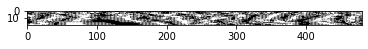

In [ ]:
plt.imshow(template, cmap='gray')

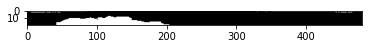

In [ ]:
plt.imshow(mask_noise, cmap='gray')

In [ ]:
# save_path = 'gdrive/MyDrive/Colab Notebooks/iris/encodings2/'


# for img_filename in tqdm(images):
#   template, mask_noise, img_filename = extractFeature(img_filename)
#   name = img_filename.split('.')
#   name = name[0].split( '/')
#   cv2.imwrite(save_path + name[-2] + '_'+name[-1]+ 'encod.bmp', template)

In [ ]:
# root_dir_train = 'gdrive/MyDrive/Colab Notebooks/iris/dataset/train/'
# images_train = []
# labels = os.listdir(root_dir_train)
# for label in labels:
#   folder = os.listdir(os.path.join(root_dir_train, label))

#   for image in folder:
#     images_train.append(os.path.join(root_dir_train,label,image))
# images_train.sort()  

In [ ]:
root_dir_test = 'gdrive/MyDrive/Colab Notebooks/iris/dataset/test/'
images_test = []
labels = os.listdir(root_dir_test)
for label in labels:
  folder = os.listdir(os.path.join(root_dir_test, label))

  for image in folder:
    images_test.append(os.path.join(root_dir_test,label,image))
images_test.sort()  

In [ ]:
from glob import glob
from scipy.io import savemat
from multiprocessing import cpu_count, Pool
from os import listdir
number_cores =cpu_count()
template_dir = 'gdrive/MyDrive/Colab Notebooks/iris/template_train/'

In [ ]:
def pool_func(file):
    template_dir = 'gdrive/MyDrive/Colab Notebooks/iris/template_test/'
    template, mask, _ = extractFeature(file, multiprocess=False)
    name = file.split('.')
    name = name[0].split( '/')
    out_file = (template_dir + name[-2] + '_'+name[-1]+ '.mat')
    savemat(out_file, mdict={'template': template, 'mask': mask, 'label': name[-2] })
# time it


n_files = len(images_test)

pools = Pool(processes=number_cores)
for _ in tqdm(pools.imap_unordered(pool_func, images_test), total=n_files):
    pass
    




  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 1/1120 [00:00<05:09,  3.61it/s]

  0%|          | 5/1120 [00:00<03:51,  4.82it/s]

  1%|          | 7/1120 [00:00<03:00,  6.17it/s]

  1%|          | 9/1120 [00:00<02:23,  7.73it/s]

  1%|          | 13/1120 [00:00<01:50, 10.00it/s]

  1%|▏         | 16/1120 [00:00<01:29, 12.37it/s]

  2%|▏         | 19/1120 [00:01<01:17, 14.28it/s]

  2%|▏         | 23/1120 [00:01<01:03, 17.16it/s]

  2%|▏         | 26/1120 [00:01<00:57, 19.15it/s]

  3%|▎         | 29/1120 [00:01<00:51, 21.18it/s]

  3%|▎         | 33/1120 [00:01<00:46, 23.17it/s]

  3%|▎         | 36/1120 [00:01<00:45, 23.78it/s]

  3%|▎         | 39/1120 [00:01<00:44, 24.06it/s]

  4%|▍         | 42/1120 [00:01<00:46, 23.26it/s]

  4%|▍         | 45/1120 [00:02<00:47, 22.80it/s]

  4%|▍         | 48/1120 [00:02<00:43, 24.48it/s]

  5%|▍         | 52/1120 [00:02<00:39, 26.84it/s]

  5%|▌         | 56/1120 [00:02<00:40, 26.20it/s]

  5%|▌         | 59/1120 [00:02<00:40, 26.

In [ ]:
def matchingTemplate(template_extr, mask_extr, template_dir, threshold=0.38):
    """
    Matching the template of the image with the ones in the database
    """
    # n# of accounts in the database
    n_files = len(filter(listdir(template_dir), '*.mat'))
    if n_files == 0:
        return -1

    # use every cores to calculate Hamming distances
    args = zip(
        sorted(listdir(template_dir)),
        repeat(template_extr),
        repeat(mask_extr),
        repeat(template_dir),
    )
    with Pool(processes=cpu_count()) as pools:
        result_list = pools.starmap(matchingPool, args)

    filenames = [result_list[i][0] for i in range(len(result_list))]
    hm_dists = np.array([result_list[i][1] for i in range(len(result_list))])
    label_list = np.array([result_list[i][2] for i in range(len(result_list))])
    # Removing NaN elements
    ind_valid = np.where(hm_dists > 0)[0]
    hm_dists = hm_dists[ind_valid]
    filenames = [filenames[idx] for idx in ind_valid]

    minhm = np.amin(hm_dists)
    index_min = np.where(hm_dists == minhm)[0][0]

    return (filenames[index_min], hm_dists[index_min], label_list[index_min][0])
    # ind_thres = np.where(hm_dists <= threshold)[0]
    # if len(ind_thres) == 0:
    #     return 0
    # else:
    #     hm_dists = hm_dists[ind_thres]
    #     filenames = [filenames[idx] for idx in ind_thres]
    #     ind_sort = np.argsort(hm_dists)
    #     return [filenames[idx] for idx in ind_sort]


def HammingDistance(template1, mask1 , template2, mask2):
    """
    Calculate the Hamming distance between two iris templates.
    """
    hd = np.nan

    # Shifting template left and right, use the lowest Hamming distance
    for shifts in range(-8, 9):
        template1s = shiftbits_ham(template1, shifts)
        mask1s = shiftbits_ham(mask1, shifts)

        mask = np.logical_or(mask1s, mask2)
        nummaskbits = np.sum(mask == 1)
        totalbits = template1s.size - nummaskbits

        C = np.logical_xor(template1s, template2)
        C = np.logical_and(C, np.logical_not(mask))
        bitsdiff = np.sum(C == 1)

        if totalbits == 0:
            hd = np.nan
        else:
            hd1 = bitsdiff / totalbits
            if hd1 < hd or np.isnan(hd):
                hd = hd1

    return hd


def shiftbits_ham(template, noshifts):
    """
    Shift the bit-wise iris patterns.
    """
    templatenew = np.zeros(template.shape)
    width = template.shape[1]
    s = 2 * np.abs(noshifts)
    p = width - s

    if noshifts == 0:
        templatenew = template

    elif noshifts < 0:
        x = np.arange(p)
        templatenew[:, x] = template[:, s + x]
        x = np.arange(p, width)
        templatenew[:, x] = template[:, x - p]

    else:
        x = np.arange(s, width)
        templatenew[:, x] = template[:, x - s]
        x = np.arange(s)
        templatenew[:, x] = template[:, p + x]

    return templatenew


def matchingPool(file_temp_name, template_extr, mask_extr, template_dir):
    """
    Perform matching session within a Pool of parallel computation
    """
    data_template = sio.loadmat('%s%s' % (template_dir, file_temp_name))
    template = data_template['template']
    mask = data_template['mask']
    label = data_template['label']
    # the Hamming distance
    hm_dist = HammingDistance(template_extr, mask_extr, template, mask)
    return (file_temp_name, hm_dist, label)

In [ ]:
from fnmatch import filter
from itertools import repeat
import scipy.io as sio

In [ ]:
i = 0
label_out = []
result_out = []
for image in tqdm(images_test):
  template, mask, label = extractFeature(image)
  result = matchingTemplate(template, mask, template_dir)
  label_out.append(label)
  result_out.append(result[2])
  if (label == result[2]):
    i = i+1




  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 1/1120 [00:05<1:39:33,  5.34s/it]

  0%|          | 2/1120 [00:10<1:38:56,  5.31s/it]

  0%|          | 3/1120 [00:15<1:38:29,  5.29s/it]

  0%|          | 4/1120 [00:21<1:38:06,  5.27s/it]

  0%|          | 5/1120 [00:26<1:37:50,  5.26s/it]

  1%|          | 6/1120 [00:31<1:39:23,  5.35s/it]

  1%|          | 7/1120 [00:37<1:40:26,  5.41s/it]

  1%|          | 8/1120 [00:43<1:41:40,  5.49s/it]

  1%|          | 9/1120 [00:48<1:42:06,  5.51s/it]

  1%|          | 10/1120 [00:54<1:42:17,  5.53s/it]

  1%|          | 11/1120 [00:59<1:42:47,  5.56s/it]

  1%|          | 12/1120 [01:05<1:43:39,  5.61s/it]

  1%|          | 13/1120 [01:11<1:43:42,  5.62s/it]

  1%|▏         | 14/1120 [01:16<1:43:41,  5.63s/it]

  1%|▏         | 15/1120 [01:22<1:42:03,  5.54s/it]

  1%|▏         | 16/1120 [01:27<1:40:16,  5.45s/it]

  2%|▏         | 17/1120 [01:32<1:38:27,  5.36s/it]

  2%|▏         | 18/1120 [01:37<1:37:09,  5.29s/it]

  2%|▏     

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [ ]:
enc  = OneHotEncoder()
y_true = enc.fit_transform(np.array(label_out).reshape(-1, 1))
y_pred = enc.transform(np.array(result_out).reshape(-1, 1))

In [ ]:

roc_auc_score(y_true =y_true.toarray() , y_score=y_pred.toarray(), multi_class='ovr') 
 

0.9417040358744394

In [ ]:
accuracy_score(y_true.toarray() , y_pred.toarray()) 

0.8839285714285714